## 1. Subir archivos

In [ ]:
#Crear carpetas de datos, logs y modelos
!mkdir data
!mkdir logs
!mkdir models

In [ ]:
#1.Subir el archivo de datos data.zip a la carpeta data
#2.Entrar en la carpeta data y descomprimir el archivo

%cd /content/data

#!unzip data.zip

import zipfile

with zipfile.ZipFile('/content/data/data.zip', 'r') as zip_ref:
    zip_ref.extractall()

%cd ..

# Output:
# This will extract all files from 'file.zip' to the current working directory



In [34]:
with zipfile.ZipFile('/content/data-test-v4.zip', 'r') as zip_ref:
    zip_ref.extractall()

## 2. Instalar dependencias

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip install Scikit-learn

In [6]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip list

In [7]:
import tensorflow as tf
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_hub as hub

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices('GPU')

[]

##3. Aumento de datos con ImageDataGenerator

In [8]:
#Clase  0 --> ardido
#Clase  1 --> brotado
#Clase  2 --> calcinado
#Clase  3 --> carbon
#Clase  4 --> helado
#Clase  5 --> panza-blanca
#Clase  6 --> picado
#Clase  7 --> roido-germen
#Clase  8 --> roido-isoca
#Clase  9 --> sano
#Clase 10 --> verde

#Aumento de datos con ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

#Crear el dataset generador
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.2 #20% para pruebas
)

#Generadores para sets de entrenamiento y pruebas
data_gen_entrenamiento = datagen.flow_from_directory('/content/data', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')
data_gen_pruebas = datagen.flow_from_directory('/content/data', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='validation')

Found 44 images belonging to 12 classes.
Found 11 images belonging to 12 classes.


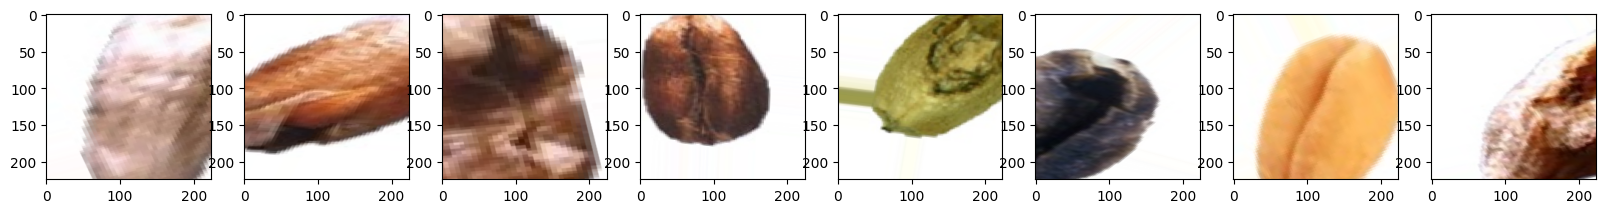

In [9]:
#Imprimir 10 imagenes del generador de entrenamiento
fig, ax = plt.subplots(ncols=8, figsize=(20, 20))
for imagen, etiqueta in data_gen_entrenamiento:
  for i in range(8):
    #plt.subplot(2,8,i+1)
    #plt.xticks([])
    #plt.yticks([])
    #plt.imshow(imagen[i])
    ax[i].imshow(imagen[i-1])

  break
plt.show()

## 8. (No Ejecutar) - Construir modelo de aprendizaje profundo

In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
# The inputs are 256x256 RGB images with `channels_last` and the batch
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))

model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
#model.add(Dense(256, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
model.add(Dense(11, activation='softmax'))


#model = tf.keras.Sequential([
#	layers.Conv2D(filters=10,
#				kernel_size=3,
#				activation="relu",
#				input_shape=(28,  28,  1)),
#	layers.Conv2D(10,  3, activation="relu"),
#	layers.MaxPool2D(),
#	layers.Conv2D(10,  3, activation="relu"),
#	layers.Conv2D(10,  3, activation="relu"),
#	layers.MaxPool2D(),
#	layers.Flatten(),
#	layers.Dense(10, activation="softmax")
#])

#model.summary()

#model.compile(loss="sparse_categorical_crossentropy",
#			optimizer=tf.keras.optimizers.Adam(),
#			metrics=["accuracy"])


In [ ]:
#model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 16)       

## 9. Construir modelo de aprendizaje profundo con transferencia de aprendizaje: MobileNetV2

In [ ]:
#!pip install mobilenetv2

In [35]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [36]:
#Congelar el modelo descargado
mobilenetv2.trainable = False

In [37]:
model = tf.keras.Sequential([
    mobilenetv2,
    tf.keras.layers.Dense(12, activation='softmax')
])

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_3 (Dense)             (None, 12)                15372     
                                                                 
Total params: 2273356 (8.67 MB)
Trainable params: 15372 (60.05 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [39]:
#Compilar
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## 7. Entrenamiento

In [40]:
logdir='logs'

In [41]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [42]:
#Entrenar el modelo
#hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
EPOCAS = 100
hist = model.fit(data_gen_entrenamiento,
                 epochs=EPOCAS,
                 batch_size=32,
                 validation_data=data_gen_pruebas,
                 callbacks=[tensorboard_callback])

Epoch 1/100
2/2 [==============================] - 9s 3s/step - loss: 2.9268 - accuracy: 0.1136 - val_loss: 2.9213 - val_accuracy: 0.0000e+00
Epoch 2/100
2/2 [==============================] - 2s 2s/step - loss: 2.5228 - accuracy: 0.0909 - val_loss: 2.2452 - val_accuracy: 0.3636
Epoch 3/100
2/2 [==============================] - 2s 2s/step - loss: 2.3109 - accuracy: 0.2727 - val_loss: 2.7318 - val_accuracy: 0.0909
Epoch 4/100
2/2 [==============================] - 2s 2s/step - loss: 2.1777 - accuracy: 0.2727 - val_loss: 1.9808 - val_accuracy: 0.3636
Epoch 5/100
2/2 [==============================] - 3s 2s/step - loss: 2.2152 - accuracy: 0.2500 - val_loss: 2.1546 - val_accuracy: 0.1818
Epoch 6/100
2/2 [==============================] - 4s 3s/step - loss: 1.8936 - accuracy: 0.4091 - val_loss: 2.3014 - val_accuracy: 0.1818
Epoch 7/100
2/2 [==============================] - 3s 2s/step - loss: 1.9373 - accuracy: 0.3636 - val_loss: 1.7250 - val_accuracy: 0.3636
Epoch 8/100
2/2 [=============

## 8. Plot Performance

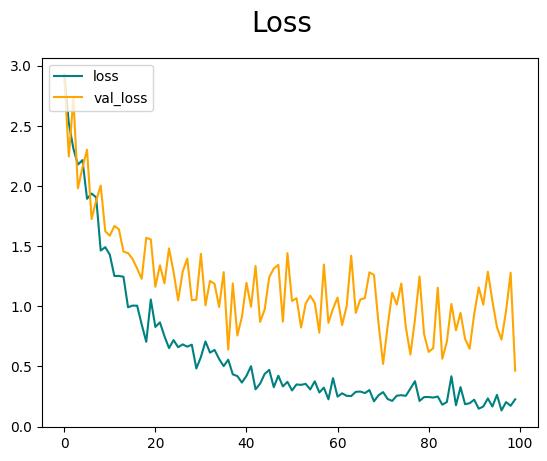

In [43]:
#loss
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

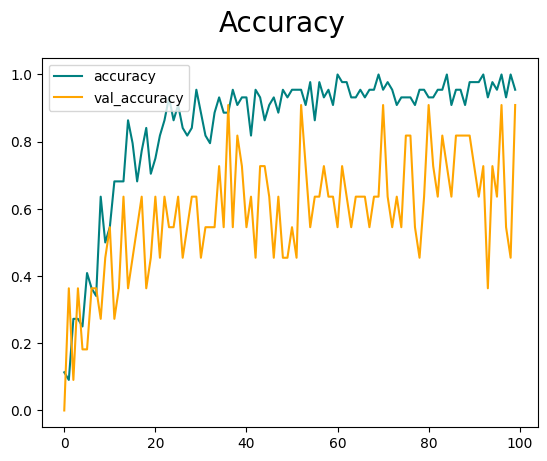

In [44]:
#accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

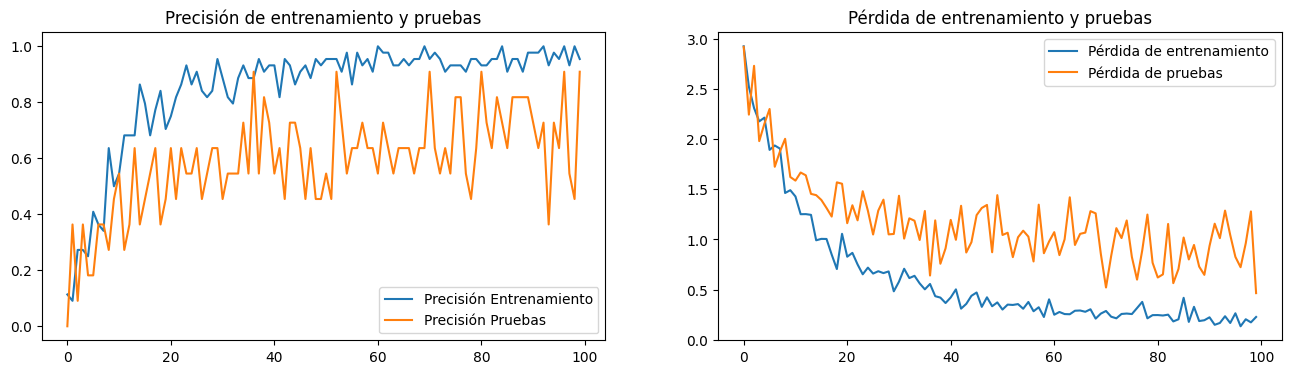

In [45]:
#Graficas de precisión
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

rango_epocas = range(EPOCAS)

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Pruebas')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y pruebas')

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Pérdida de entrenamiento')
plt.plot(rango_epocas, val_loss, label='Pérdida de pruebas')
plt.legend(loc='upper right')
plt.title('Pérdida de entrenamiento y pruebas')
plt.show()

In [46]:
datagen_test = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 30,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    validation_split=0.1 #80% para pruebas
)

In [47]:
data_gen_test = datagen_test.flow_from_directory('/content/data-test-v4', target_size=(224,224),
                                                     batch_size=32, shuffle=True, subset='training')

Found 33 images belonging to 11 classes.


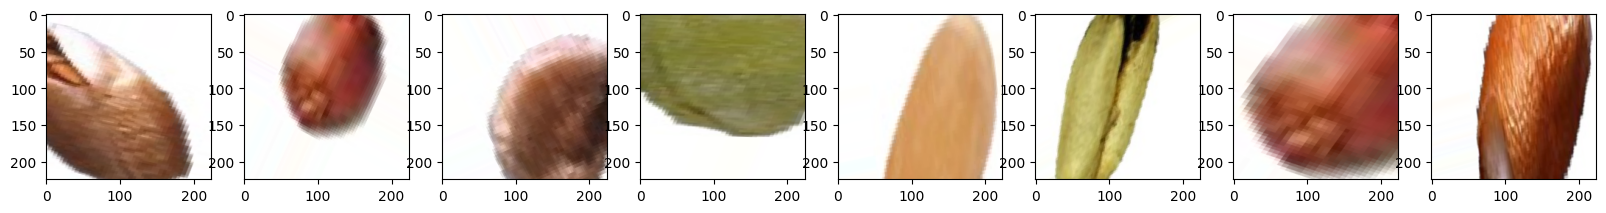

In [48]:
fig, ax = plt.subplots(ncols=8, figsize=(20, 20))
for imagen, etiqueta in data_gen_test:
  for i in range(8):
    #plt.subplot(2,8,i+1)
    #plt.xticks([])
    #plt.yticks([])
    #plt.imshow(imagen[i])
    ax[i].imshow(imagen[i-1])

  break
plt.show()

In [49]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [59]:
width_shape = 224
height_shape = 224
batch_size = 32

names = ['00-ardido', '01-brotado', '02-calcinado', '03-carbon',
         '04-helado', '05-panza-blanca', '06-picado', '07-roido-germen',
         '08-roido-isoca', '09-sano', '10-verde', '11-no-identificado']

In [60]:
predictions = model.predict(data_gen_test)
y_pred = np.argmax(predictions, axis=1)
y_real = data_gen_test.classes

2/2 [==============================] - 2s 36ms/step


In [61]:
y_pred

array([ 1, 10,  1,  2, 11,  1,  2,  8,  1,  7,  6,  2,  8,  1,  6,  5,  2,
        7,  6, 10, 11,  8, 11, 10,  4,  4,  2,  3,  4,  6,  8,  5,  9])

In [62]:
y_real

array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
        5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10],
      dtype=int32)

/usr/local/lib/python3.10/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pr

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         3
           1     0.2000    0.3333    0.2500         3
           2     0.2000    0.3333    0.2500         3
           3     0.0000    0.0000    0.0000         3
           4     0.0000    0.0000    0.0000         3
           5     0.5000    0.3333    0.4000         3
           6     0.2500    0.3333    0.2857         3
           7     0.0000    0.0000    0.0000         3
           8     0.0000    0.0000    0.0000         3
           9     0.0000    0.0000    0.0000         3
          10     0.0000    0.0000    0.0000         3
          11     0.0000    0.0000    0.0000         0

    accuracy                         0.1212        33
   macro avg     0.0958    0.1111    0.0988        33
weighted avg     0.1045    0.1212    0.1078        33



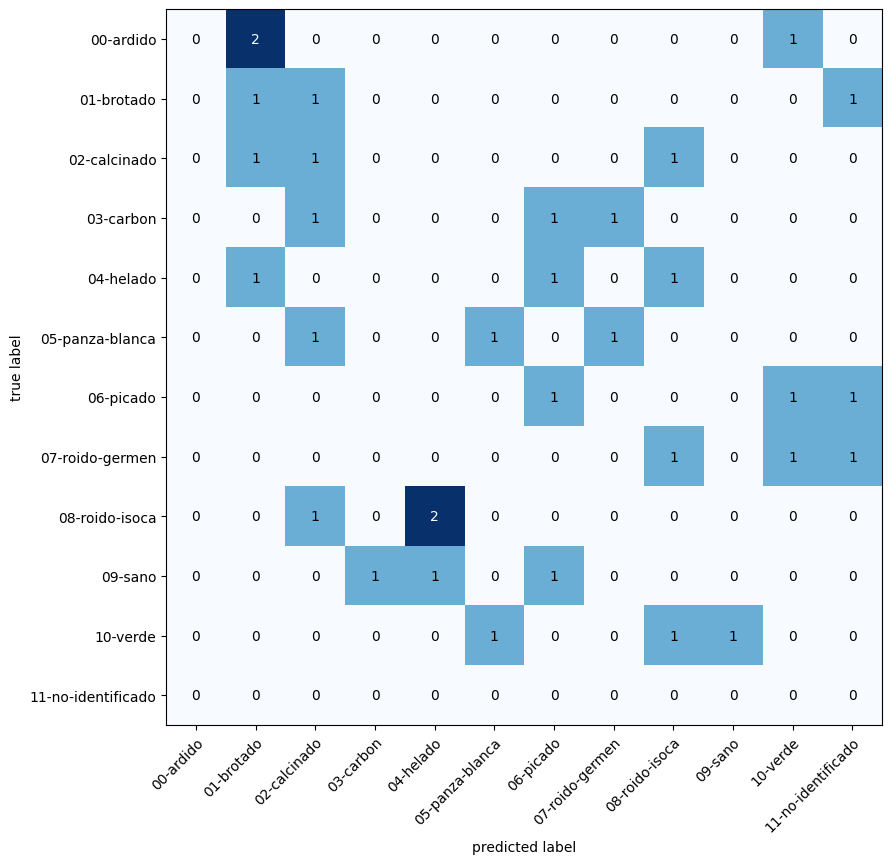

In [63]:
matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(9,9), class_names = names, show_normed=False)
#plot_confusion_matrix(conf_mat=matc, figsize=(9,9), show_normed=False)
plt.tight_layout()

print(metrics.classification_report(y_real,y_pred, digits = 4))

## 9. Guardar el modelo

In [64]:
from tensorflow.keras.models import load_model

In [65]:
model.save(os.path.join('models','clasificadorDeGranos-MobileNetV2-v6.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 10. Evaluación

### 10.1. Cargar modelo

In [66]:
new_model = load_model('/content/models/clasificadorDeGranos-MobileNetV2-v6.h5',
                       custom_objects={'KerasLayer':hub.KerasLayer})

### 10. 2 Cargar imágenes de test que no estan en el dataset

In [67]:
#Crear carpeta y subir manualmente o con zip
!mkdir data_test

In [ ]:
import cv2
imagen = cv2.imread('/content/data_test/ardido/ardido_06.jpg')
# converting BGR to RGB
imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
imagen = tf.image.resize(imagen, (224,224))
plt.imshow(imagen.numpy().astype(int))

In [ ]:
yhat = new_model.predict(np.expand_dims(imagen/255, 0))
#yhat
clase_nombres = ['00-ardido', '01-brotado', '02-calcinado', '03-carbon', '04-helado', '05-panza-blanca', '06-picado', '07-roido-germen', '08-roido-isoca', '09-sano', '10-verde']
clase = yhat.argmax()
clasificacion = "Imagen clasificada como " + clase_nombres[clase]
print(clasificacion)

In [ ]:
yhat